In [15]:
from diffusion_policy.model.common.se3_diffusion_util import marginal_prob_std, sample_from_se3_gaussian, se3_score_normal, step
from diffusion_policy.dataset.rlbench_dataset import RLBenchDataset
from diffusion_policy.common.pytorch_util import dict_apply
import numpy as np
import torch
from theseus.geometry import SO3
from my_tests.utils.grasp_visualization import visualize_grasps
from trimesh import viewer
from IPython import display

In [16]:
from hydra import compose, initialize
from omegaconf import OmegaConf
import hydra
from diffusion_policy.policy.diffusion_unet_lowdim_relative_policy import DiffusionUnetLowDimRelativePolicy
from diffusion_policy.workspace.train_diffusion_unet_lowdim_relative_workspace import TrainDiffusionUnetLowDimRelativeWorkspace
hydra_run_dir = "/home/felix/Workspace/diffusion_policy_felix/data/outputs/2024.03.07/15.54.55_diffusion_unet_lowdim_relative_policy_open_drawer"
with initialize(version_base=None, config_path="../diffusion_policy/config"):
    cfg = compose(config_name="train_diffusion_unet_lowdim_relative_workspace", overrides=['hydra.run.dir='])

OmegaConf.resolve(cfg)

workspace = TrainDiffusionUnetLowDimRelativeWorkspace(cfg=cfg, output_dir=hydra_run_dir)
ckpt_path = workspace.get_checkpoint_path()
workspace.get_checkpoint_path(ckpt_path)
model = workspace.model
dataset = hydra.utils.instantiate(cfg.task.dataset)

Gripper workspace size: [0.67823578 0.99414986 0.71873248]

============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['agent_pose', 'keypoint_idx', 'keypoint_pcd']
using obs modality: rgb with keys: []
using obs modality: depth with keys: []
using obs modality: scan with keys: []
Diffusion params: 1.807600e+05
Vision params: 2.233800e+05


In [17]:
batch = dict_apply(dataset[0], lambda x: torch.tensor(x).unsqueeze(0))
x_tar = batch['action'][:,-1,:3,3].float()
R_tar = batch['action'][:,-1,:3,:3].float()
H_tar = torch.eye(4)
H_tar[:3,:3] = R_tar
H_tar[:3,3] = x_tar

/tmp/ipykernel_2166321/150346021.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = dict_apply(dataset[0], lambda x: torch.tensor(x).unsqueeze(0))


In [18]:
def compute_pos_mse(x_pred, x_tar):
    return ((x_pred - x_tar.unsqueeze(0)) ** 2).mean(dim=-1)

def compute_rot_mse(R_pred, R_tar):
    delta_R = SO3()
    delta_R.update((R_pred @ R_tar.unsqueeze(0).transpose(-1,-2)))
    delta_log = delta_R.log_map()
    return (delta_log ** 2).mean(dim=-1)

def sample(score_fn, T=1000,dt=0.01):
    H_trj = torch.zeros(0,4,4).float()
    R0 = SO3.rand(1).to_matrix()
    x0 = torch.randn(1, 3).float()
    for t in range(T):
        k = (T - t)/T + 10e-3
        H0 = torch.eye(4)
        H0[:3, :3] = R0.detach()[0,...]
        H0[:3, -1] = x0.detach()[0,...]
        H_trj = torch.cat((H_trj, H0[None,...]), dim=0)
        v = score_fn(x0, R0, k=k*torch.ones(x0.shape[0]))
        _s = v*dt
        x0, R0 = step(x0, R0, _s)
    return H_trj

def visualize_grap_trajectory(H_trj, H_tar):
    Hs=torch.cat((H_trj, H_tar.unsqueeze(0)), dim=0)
    colors=torch.zeros_like(Hs[:,:3,-1])
    colors[:-1,1] = torch.linspace(0,1,Hs.shape[0]-1)
    colors[:-1,0] = 1 - colors[:-1,1]
    colors[-1,1] = 1
    scene = visualize_grasps(Hs=Hs, colors=colors.numpy(), show=False)
    return scene

In [19]:
T = 100
dt= 0.01
score_fn_se3_normal = lambda x, R, k: se3_score_normal(x, R, x_tar, R_tar, std=marginal_prob_std(k))
H_trj = sample(score_fn_se3_normal, T=T, dt=dt)

scene = visualize_grap_trajectory(H_trj, H_tar)
display.display(scene.show())

pos_mse = compute_pos_mse(H_trj[:,:3,-1], H_tar[:3,-1])
rot_mse = compute_rot_mse(H_trj[:,:3,:3], H_tar[:3,:3])

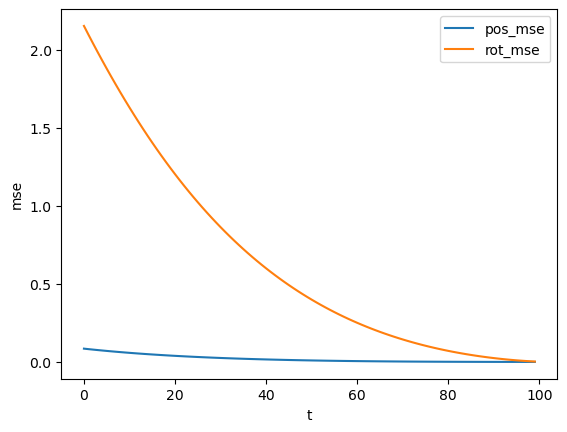

In [20]:
import matplotlib.pyplot as plt
plt.plot(pos_mse, label='pos_mse')
plt.plot(rot_mse, label='rot_mse')
plt.legend()
plt.xlabel('t')
plt.ylabel('mse')
plt.show()

In [21]:
from copy import deepcopy

def score_fn_model(x, R, k):
    # normalize input
    nobs = model.normalize_obs(deepcopy(batch["obs"]))
    To = model.n_obs_steps

    # build input
    device = model.device
    dtype = model.dtype
    nobs = dict_apply(nobs, lambda x: x.type(dtype).to(device))
    x_curr = nobs['agent_pose'][:,-1,:3,3].clone()
    R_curr = nobs['agent_pose'][:,-1,:3,:3].clone()

    if model.relative_trajectory:
        nobs = model.convert2rel(x_curr, R_curr, nobs)

    # condition through global feature
    this_nobs = dict_apply(nobs, lambda x: x[:,:To,...]) # We need to keep the observation shape
    # (B, D)
    global_cond = model.obs_encoder(this_nobs)

    v = model.model(x, R, k, global_cond=global_cond)
    return v


In [52]:
Hp = model.predict_action(deepcopy(batch['obs']))['action'][0].detach()
Ht = batch['action'][:,-1].detach()[0]
scene = visualize_grap_trajectory(Hp, Ht)
display.display(scene.show())

In [23]:
T = 10
dt = 0.1
H_trj = sample(score_fn_model, T=T, dt=dt)

scene = visualize_grap_trajectory(H_trj, H_tar)
display.display(scene.show())
pos_mse = compute_pos_mse(H_trj[:,:3,-1], H_tar[:3,-1])
rot_mse = compute_rot_mse(H_trj[:,:3,:3], H_tar[:3,:3])

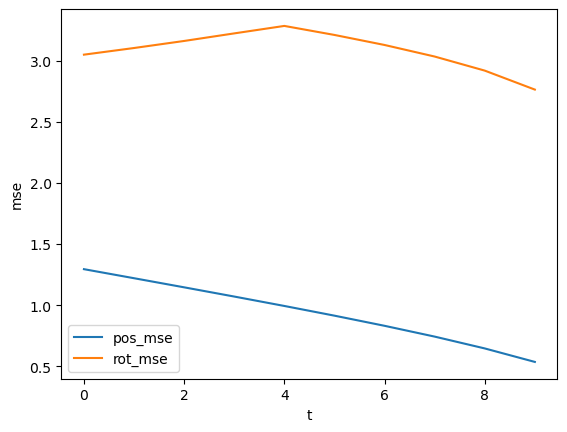

In [24]:
import matplotlib.pyplot as plt
plt.plot(pos_mse, label='pos_mse')
plt.plot(rot_mse, label='rot_mse')
plt.legend()
plt.xlabel('t')
plt.ylabel('mse')
plt.show()